# Pneumonia Detection


## Dataset

- [kaggle Chest X-Ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
- 5,856 X-Ray images (JPEG)
- 2 categories (Pneumonia/Normal)
- Organized into 3 folders (train, test, val)
- Datset size: 1.2 GB
- From the hospital for female and children(1~5 yr) in China

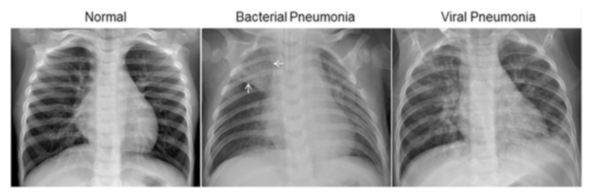

## Baseline Kernal

- [Overall](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)

- 1) 실험 환경 set-up
    - batch size
    - epoch
- 2) 데이터 준비하기
    - data augmentation
- 3) 데이터 시각화
    - show_batch() 함수 이용해서 augmentation 결과 확인
- 4) CNN 모델링
    - conv filter, 채널 개수, activation, 모델 구조 등을 바꿔보기
    - batch normalization과 dropout 둘 중 하나만 써보거나
    - dropout 비율 조정해보기
- 5) 데이터 imbalance 처리
    - class_weight 처리를 안 하면 어떻게 될까?
    - recall을 강조하기 위해 더 강화할 수 있을까?
- 6) 모델 훈련
    - optimizer, learning rate 등 조정
- 7) 결과 확인, 시각화
    - 분석을 더 자세히 해보기

In [15]:
import math
import os
import random
import re

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [229]:
# for faster data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY image size
IMAGE_SIZE = [180, 180]

# path for datatset
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/aiffel_projects/exploration/E11_chest_xray/data')
TRAIN_PATH = ROOT_PATH + '/train/*/*'
VAL_PATH = ROOT_PATH + '/val/*/*'
TEST_PATH = ROOT_PATH + '/test/*/*'

# hyperparameters for training
BATCH_SIZE = 8
EPOCHS = 22

print(ROOT_PATH)

/aiffel/aiffel/aiffel_projects/exploration/E11_chest_xray/data


In [164]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train dataset:", len(train_filenames))
print("test dataset:", len(test_filenames))
print("val dataset:", len(val_filenames))

train dataset: 5216
test dataset: 624
val dataset: 16


### Split train and validation dataset with 8:2 ratio

In [165]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train dataset:", len(train_filenames))
print("val dataset:", len(val_filenames))

train dataset: 4185
val dataset: 1047


In [166]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}\n')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/aiffel_projects/exploration/E11_chest_xray/data/train/PNEUMONIA/person26_bacteria_124.jpeg

Pneumonia image path
/aiffel/aiffel/aiffel_projects/exploration/E11_chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [167]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


In [168]:
# tf.data 인스턴스 생성
# tf.data로 배치처리 작업을 효율적으로 할 수 있다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [169]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [170]:
# 파일 경로의 끝에서 두번째 부분을 확인
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    # 폐렴이면 양성(True), 노말이면 음성(False)
    return parts[-2] == "PNEUMONIA"

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [171]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    # 이미지를 uint8 tensor로 수정
    img = tf.image.decode_jpeg(img, channels=3) 
    # float32 타입으로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # 이미지 사이즈를 IMAGE_SIZE로 수정
    img = tf.image.resize(img, IMAGE_SIZE) 
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

In [172]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [173]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [174]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("test dataset: ", TEST_IMAGE_COUNT)

test dataset:  624


tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용

- prepare_for_training() 함수는 학습을 효율적으로 할 수 있도록 데이터를 변환
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용.
    - 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
    - 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.
- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [175]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

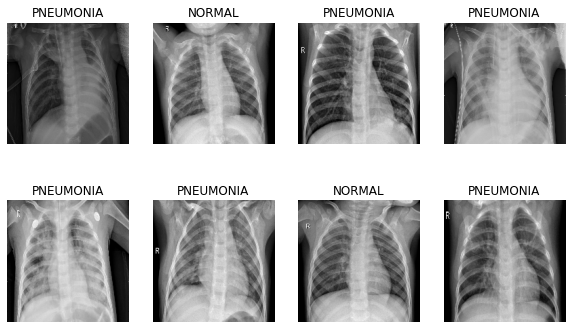

In [176]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,int(BATCH_SIZE*0.8)))
    
    for n in range(BATCH_SIZE):
        ax = plt.subplot(math.ceil(BATCH_SIZE/4),4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

- Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용
- [논문](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

- 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. [이 논문](https://arxiv.org/pdf/1905.05928.pdf)은 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

In [177]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [178]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [230]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.4),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리

- 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.
- 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다.
- Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 

In [215]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


## Train

In [231]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [224]:
callback = EarlyStopping(monitor='precision', patience=5)

In [232]:
model.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_128 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_129 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_130 (Sequential)  (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_80 (Dropout)         (None, 11, 11, 128)    

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
#         callbacks=[callback],
        verbose=1
    )

Epoch 1/22
523/523 [==============================] - 50s 78ms/step - loss: 0.5185 - accuracy: 0.7321 - precision: 0.9153 - recall: 0.6990 - val_loss: 1.3074 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/22
523/523 [==============================] - 40s 77ms/step - loss: 0.2796 - accuracy: 0.8831 - precision: 0.9632 - recall: 0.8761 - val_loss: 0.2887 - val_accuracy: 0.8750 - val_precision: 0.9969 - val_recall: 0.8348
Epoch 3/22
523/523 [==============================] - 40s 76ms/step - loss: 0.2451 - accuracy: 0.8966 - precision: 0.9742 - recall: 0.8842 - val_loss: 0.2169 - val_accuracy: 0.9058 - val_precision: 1.0000 - val_recall: 0.8739
Epoch 4/22
523/523 [==============================] - 40s 76ms/step - loss: 0.2375 - accuracy: 0.8964 - precision: 0.9730 - recall: 0.8853 - val_loss: 0.1425 - val_accuracy: 0.9385 - val_precision: 0.9931 - val_recall: 0.9240
Epoch 5/22
523/523 [==============================] - 40s 76ms/step - loss: 0.1930 - accuracy: 0

## Evaluate

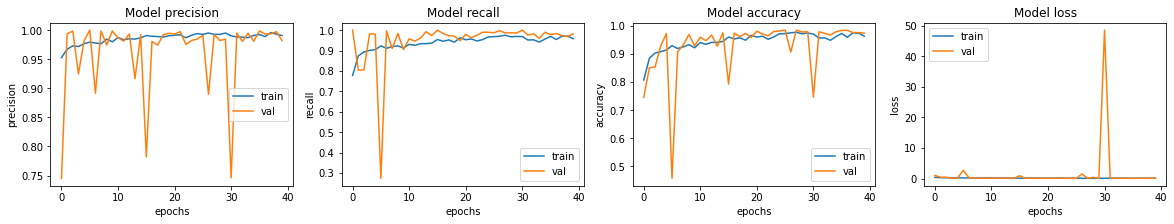

In [227]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [228]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'\nLoss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 4s 44ms/step - loss: 6.4905 - accuracy: 0.8333 - precision: 0.7930 - recall: 0.9923

Loss: 6.49047327041626,
Accuracy: 0.8333333134651184,
Precision: 0.7930327653884888,
Recall: 0.9923076629638672


In [ ]:
# 좌우 반전 data augmentation
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

## 1) Batch, Epoch 조정

#### First try

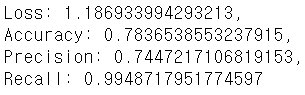

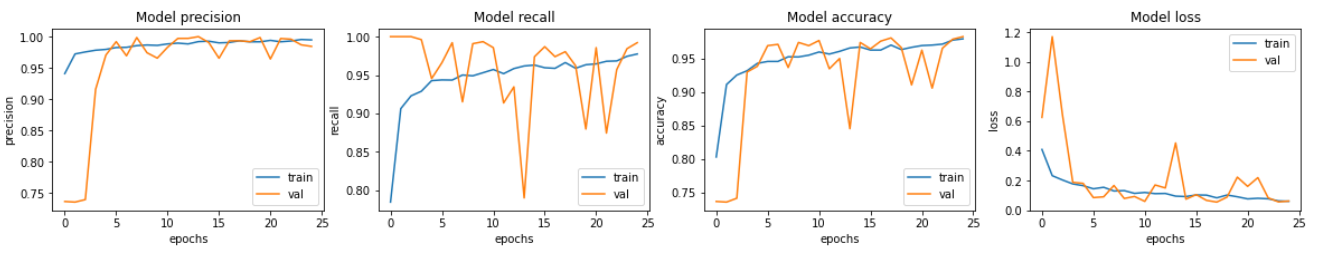

#### Second Try

- epoch=50, earlystopping
- batch=10

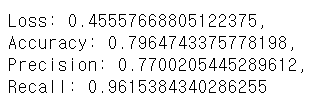

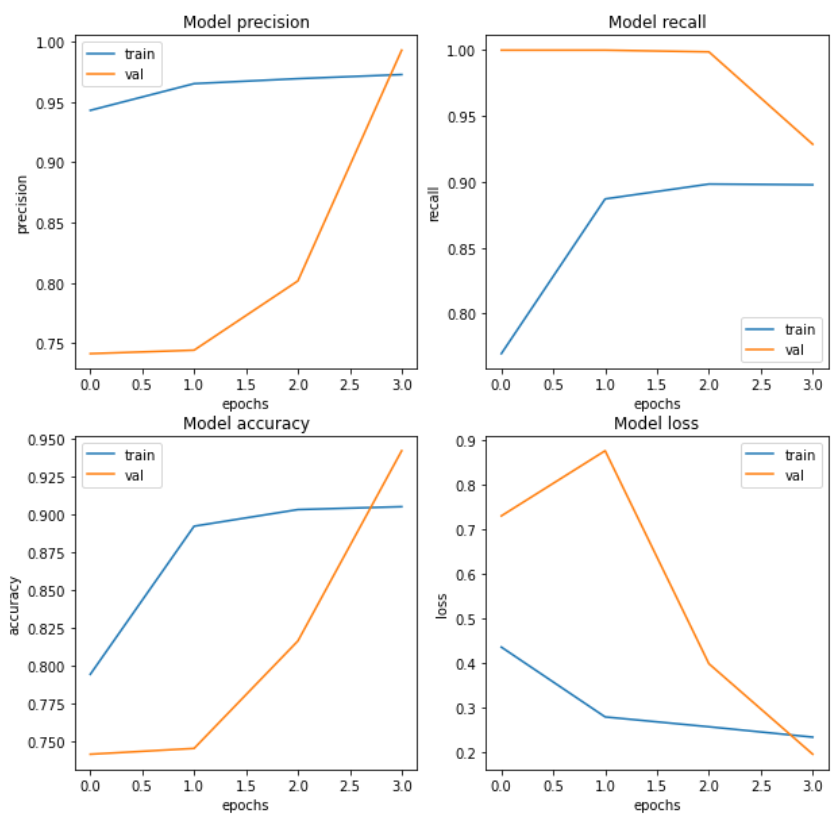

#### Third try
- batch=8, epoch=30
- without earlystopping

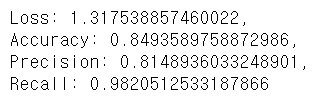

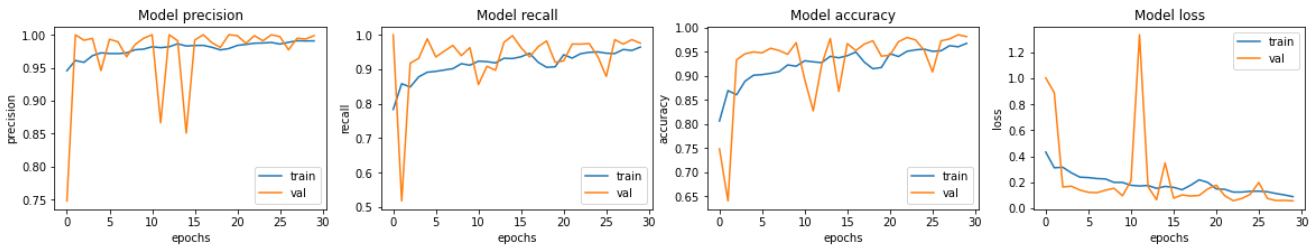

## 2) Dropout 조정

- zero-try

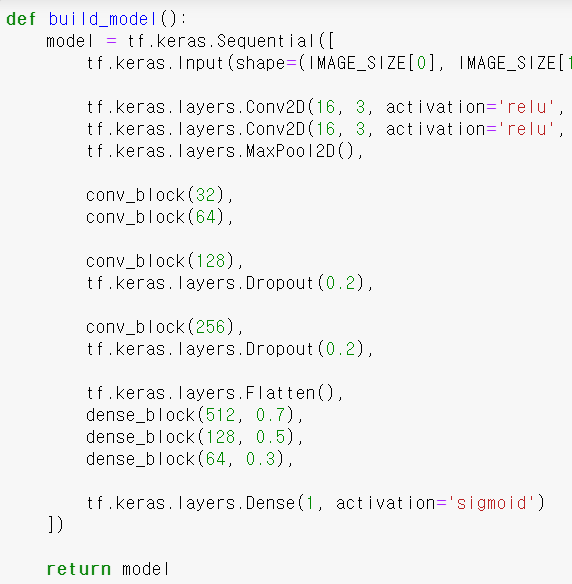